# Insurance Recommender Engine
Get user health data with smart watch APIs, then analyse & predict their health condition. Based on prediction, we can recommend a best fit insurance.

Dataset is a sample of 46 participants (26 women) to wear three devices, a GENEActiv, and Apple Watch Series 2, a Fitbit Charge HR2. Participants completed a 65-minute protocol with 40-minutes of total treadmill time and 25-minutes of sitting or lying time.
Dataset: https://www.kaggle.com/datasets/aleespinosa/apple-watch-and-fitbit-data

## Setup

In [198]:
import sys
sys.path.append('..')


In [199]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report


## 1. Data Analysis

In [201]:
# display first 10 rows
df = pd.read_csv('../datasets/people/aw_fb_data.csv')

df.head(5)


,Unnamed: 0,X1,age,gender,height,weight,steps,hear_rate,calories,distance,entropy_heart,entropy_setps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance,device,activity
0,1,1,20,1,168.0,65.4,10.771429,78.531302,0.344533,0.008327,6.221612,6.116349,59.0,1.000000,19.531302,0.138520,1.000000,0.089692,apple watch,Lying
1,2,2,20,1,168.0,65.4,11.475325,78.453390,3.287625,0.008896,6.221612,6.116349,59.0,1.000000,19.453390,0.137967,1.000000,0.102088,apple watch,Lying
2,3,3,20,1,168.0,65.4,12.179221,78.540825,9.484000,0.009466,6.221612,6.116349,59.0,1.000000,19.540825,0.138587,1.000000,0.115287,apple watch,Lying
3,4,4,20,1,168.0,65.4,12.883117,78.628260,10.154556,0.010035,6.221612,6.116349,59.0,1.000000,19.628260,0.139208,1.000000,0.129286,apple watch,Lying
4,5,5,20,1,168.0,65.4,13.587013,78.715695,10.825111,0.010605,6.221612,6.116349,59.0,0.982816,19.715695,0.139828,0.241567,0.144088,apple watch,Lying


In [202]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6264 entries, 0 to 6263
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6264 non-null   int64  
 1   X1                    6264 non-null   int64  
 2   age                   6264 non-null   int64  
 3   gender                6264 non-null   int64  
 4   height                6264 non-null   float64
 5   weight                6264 non-null   float64
 6   steps                 6264 non-null   float64
 7   hear_rate             6264 non-null   float64
 8   calories              6264 non-null   float64
 9   distance              6264 non-null   float64
 10  entropy_heart         6264 non-null   float64
 11  entropy_setps         6264 non-null   float64
 12  resting_heart         6264 non-null   float64
 13  corr_heart_steps      6264 non-null   float64
 14  norm_heart            6264 non-null   float64
 15  intensity_karvonen   

In [203]:
df.describe()


,Unnamed: 0,X1,age,gender,height,weight,steps,hear_rate,calories,distance,entropy_heart,entropy_setps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance
count,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000
mean,3132.500000,1771.144317,29.158525,0.476533,169.709052,69.614464,109.562268,86.142331,19.471823,13.832555,6.030314,5.739984,65.869938,0.306447,20.272393,0.155479,8.110854,590.035239
std,1808.405375,1097.988748,8.908978,0.499489,10.324698,13.451878,222.797908,28.648385,27.309765,45.941437,0.765574,1.256348,21.203017,0.775418,28.388116,0.210927,12.535080,4063.838530
min,1.000000,1.000000,18.000000,0.000000,143.000000,43.000000,1.000000,2.222222,0.056269,0.000440,0.000000,0.000000,3.000000,-1.000000,-76.000000,-2.714286,0.000000,0.000690
25%,1566.750000,789.750000,23.000000,0.000000,160.000000,60.000000,5.159534,75.598079,0.735875,0.019135,6.108524,5.909440,58.134333,-0.467303,1.148883,0.009819,0.264722,0.659260
50%,3132.500000,1720.000000,28.000000,0.000000,168.000000,68.000000,10.092029,77.267680,4.000000,0.181719,6.189825,6.157197,75.000000,0.665829,9.820254,0.079529,2.893503,13.368619
75%,4698.250000,2759.250000,33.000000,1.000000,180.000000,77.300000,105.847222,95.669118,20.500000,15.697188,6.247928,6.247928,76.138701,1.000000,27.077336,0.211868,9.679672,93.728562
max,6264.000000,3670.000000,56.000000,1.000000,191.000000,115.000000,1714.000000,194.333333,97.500000,335.000000,6.475733,6.475733,155.000000,1.000000,156.319444,1.297980,74.457929,51520.000000


In [204]:
# display shape of the dataset
df.shape


(6264, 20)

The dataset contains 6264 rows and 20 columns.

In [205]:
# unique value of "activity" column
df['activity'].unique()


array(['Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs'], dtype=object)

According to result above, there are 7 differet activities.

In [206]:
# count total number of each activity
df.activity.value_counts()


Lying             1379
Running 7 METs    1114
Running 5 METs    1002
Running 3 METs     950
Sitting            930
Self Pace walk     889
Name: activity, dtype: int64

In [207]:
# display type of data
df.dtypes.value_counts()


float64    14
int64       4
object      2
dtype: int64

### Plot object type data

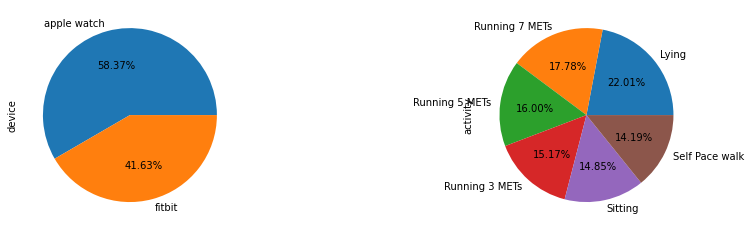

In [208]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
df['device'].value_counts().plot.pie(autopct='%.2f%%', ax=ax1)
df['activity'].value_counts().plot.pie(autopct='%.2f%%', ax=ax2)
plt.show()


### Plot activities of each device on heatmap

<AxesSubplot:xlabel='device', ylabel='activity'>

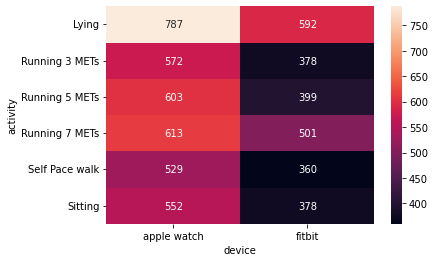

In [209]:
sns.heatmap(pd.crosstab(df["activity"], df["device"]), annot=True, fmt='d')


## 2. Data Preprocessing

Prepare useful columns that will be used for building model

In [210]:
df = df[["hear_rate", "steps", "distance", "calories",
         "resting_heart", "age", "gender", "height", "weight", "device", "activity"]]


In [211]:
# display null value
df.isna().sum()


hear_rate        0
steps            0
distance         0
calories         0
resting_heart    0
age              0
gender           0
height           0
weight           0
device           0
activity         0
dtype: int64

Plot columns on heatmap to see correlation

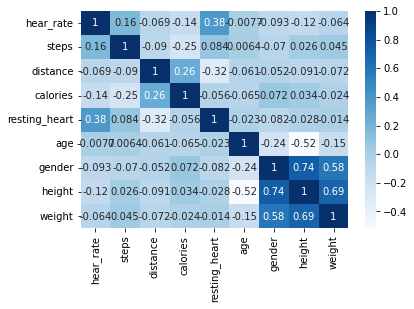

In [212]:
ax = plt.subplots()
ax = sns.heatmap(df.corr(), annot=True, cmap="Blues")


<AxesSubplot:>

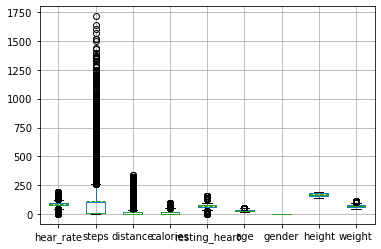

In [213]:
df.boxplot(meanline=True, showmeans=True)


According to the boxplot above, we are able to know that the dataset contains outlier.

In [214]:
# remove outlier using interquartile range (IQR)
def outlier(col):
    Q3, Q1 = np.nanpercentile(col, [75, 25])
    IQR = Q3 - Q1
    UL = Q3 + 1.5*IQR
    LL = Q1 - 1.5*IQR
    return UL, LL


In [215]:
for column in df.columns:
    if df[column].dtype != 'object':
        UL, LL = outlier(df[column])
        df[column] = np.where((df[column] > UL) | (
            df[column] < LL), np.nan, df[column])


In [216]:
# display null value
df.isna().sum()


hear_rate        1050
steps             814
distance          278
calories         1149
resting_heart     634
age               390
gender              0
height              0
weight            158
device              0
activity            0
dtype: int64

In [217]:
# drop outlier
df.dropna()


,hear_rate,steps,distance,calories,resting_heart,age,gender,height,weight,device,activity
0,78.531302,10.771429,0.008327,0.344533,59.000000,20.0,1.0,168.0,65.4,apple watch,Lying
1,78.453390,11.475325,0.008896,3.287625,59.000000,20.0,1.0,168.0,65.4,apple watch,Lying
2,78.540825,12.179221,0.009466,9.484000,59.000000,20.0,1.0,168.0,65.4,apple watch,Lying
3,78.628260,12.883117,0.010035,10.154556,59.000000,20.0,1.0,168.0,65.4,apple watch,Lying
4,78.715695,13.587013,0.010605,10.825111,59.000000,20.0,1.0,168.0,65.4,apple watch,Lying
...,...,...,...,...,...,...,...,...,...,...,...
6189,75.708658,1.750000,15.782895,25.500000,75.686542,36.0,0.0,172.0,86.4,fitbit,Running 7 METs
6190,75.686542,1.631579,15.784211,25.500000,75.686542,36.0,0.0,172.0,86.4,fitbit,Running 7 METs
6191,75.664427,1.513158,15.785526,30.000000,75.686542,36.0,0.0,172.0,86.4,fitbit,Running 7 METs
6192,75.642311,1.394737,15.786842,31.000000,75.686542,36.0,0.0,172.0,86.4,fitbit,Running 7 METs


In [218]:
# drop null value of X
df = df.dropna(axis=0)


In [219]:
# Split dataset based on device type (Apple and Fitbit)
df_apple = df.loc[df["device"] == "apple watch"]
df_fitbit = df.loc[df["device"] == "fitbit"]

# Remove "device" column
df_apple = df_apple.drop("device", axis=1)
df_fitbit = df_fitbit.drop("device", axis=1)


## 3. Training

### 3.1. Split Apple & Fitbit data

In [220]:
# Prepare data for training (Apple)
X = df_apple.drop("activity", axis=1)
y = df_apple.loc[:, "activity"]


In [221]:
# Prepare data for training (Fitbit)
X = df_fitbit.drop("activity", axis=1)
y = df_fitbit.loc[:, "activity"]


### 3.2. Feature encoding

In [222]:
# Display unique value of activity (Apple)
df_apple['activity'].unique()


array(['Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs'], dtype=object)

In [223]:
# Display unique value of activity (Fitbit)
df_fitbit['activity'].unique()


array(['Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs'], dtype=object)

In [224]:
# Feature encoding
def one_hot_encoding(df):
    ordinal_encoder = ce.OrdinalEncoder(cols=['activity'],
                                        mapping=[
        {'col': 'activity', 'mapping': {
            'Lying': 0, 'Self Pace walk': 1, 'Running 3 METs': 2, 'Running 5 METs': 3, 'Sitting': 4, 'Running 7 METs': 5}},
    ])

    df_ = ordinal_encoder.fit_transform(df)
    return df_


In [225]:
def preprocessing(df):
    df = one_hot_encoding(df)
    X = df.drop("activity", axis=1)
    y = df.loc[:, "activity"]
    return X, y


### 3.3. Prepare Dataset
Split 20% of data for testing

In [226]:
Apple_trainset, Apple_testset = train_test_split(
    df_apple, test_size=0.2, random_state=0)
fitbit_trainset, fitbit_testset = train_test_split(
    df_fitbit, test_size=0.2, random_state=0)


In [227]:
XApple_train, yApple_train = preprocessing(Apple_trainset)
Xfitbit_train, yfitbit_train = preprocessing(fitbit_trainset)


In [228]:
Xfitbit_test, yfitbit_test = preprocessing(fitbit_testset)
XApple_test, yApple_test = preprocessing(Apple_testset)


### 3.4. Standardization

In [229]:
def standardisation(df):
    scaler = StandardScaler()
    X = scaler.fit_transform(df)
    return X


In [230]:
XApple_train = standardisation(XApple_train)
Xfitbit_test = standardisation(Xfitbit_test)
XApple_test = standardisation(XApple_test)
Xfitbit_train = standardisation(Xfitbit_train)


## 4. Evaluation

In [231]:
def evaluate_model(model, Xtrain, Ytrain, Xtest, Ytest):
    model.fit(Xtrain, Ytrain)
    ypred = model.predict(Xtest)
    print(classification_report(Ytest, ypred))
    print("Training accuracy {}".format(model.score(Xtrain, Ytrain)))
    print("Testing accuracy {}".format(model.score(Xtest, Ytest)))


### 4.1. Decision Tree Model

In [232]:
tree = DecisionTreeClassifier(criterion='gini', random_state=42, max_depth=13)


In [233]:
# Decision tree for Apple Watch
evaluate_model(tree, XApple_train, yApple_train, XApple_test, yApple_test)


              precision    recall  f1-score   support

           0       0.36      0.38      0.37        98
           1       0.52      0.41      0.46        75
           2       0.55      0.50      0.52        98
           3       0.51      0.50      0.50        70
           4       0.30      0.40      0.34        55
           5       0.51      0.53      0.52        49

    accuracy                           0.45       445
   macro avg       0.46      0.45      0.45       445
weighted avg       0.46      0.45      0.45       445

Training accuracy 0.9527293190770962
Testing accuracy 0.449438202247191


In [234]:
# Decision tree for Fitbit
evaluate_model(tree, Xfitbit_train, yfitbit_train, Xfitbit_test, yfitbit_test)


              precision    recall  f1-score   support

           0       0.97      0.33      0.50        87
           1       0.33      0.17      0.22         6
           2       0.00      0.00      0.00         6
           3       0.10      0.89      0.17         9
           4       0.38      0.20      0.26        40
           5       0.72      1.00      0.84        26

    accuracy                           0.41       174
   macro avg       0.42      0.43      0.33       174
weighted avg       0.70      0.41      0.45       174

Training accuracy 1.0
Testing accuracy 0.41379310344827586


### 4.2. Support-vector machine model

In [235]:
SVM = SVC()


In [236]:
# SVM for Apple Watch
evaluate_model(SVM, XApple_train, yApple_train, XApple_test, yApple_test)


              precision    recall  f1-score   support

           0       0.31      0.70      0.43        98
           1       0.48      0.33      0.39        75
           2       0.57      0.38      0.45        98
           3       0.55      0.47      0.51        70
           4       0.38      0.11      0.17        55
           5       0.61      0.35      0.44        49

    accuracy                           0.42       445
   macro avg       0.48      0.39      0.40       445
weighted avg       0.47      0.42      0.41       445

Training accuracy 0.46933033202025887
Testing accuracy 0.4202247191011236


In [237]:
# SVM for Fitbit
evaluate_model(SVM, Xfitbit_train, yfitbit_train, Xfitbit_test, yfitbit_test)


              precision    recall  f1-score   support

           0       0.62      0.84      0.72        87
           1       0.33      0.33      0.33         6
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         9
           4       0.38      0.12      0.19        40
           5       0.68      1.00      0.81        26

    accuracy                           0.61       174
   macro avg       0.34      0.38      0.34       174
weighted avg       0.51      0.61      0.53       174

Training accuracy 0.6060606060606061
Testing accuracy 0.6091954022988506


### 4.3. K-nearest Neighbors Classifier Model

In [238]:
KNN = KNeighborsClassifier()


In [239]:
# KNN for Apple Watch
evaluate_model(KNN, XApple_train, yApple_train, XApple_test, yApple_test)


              precision    recall  f1-score   support

           0       0.65      0.62      0.64        98
           1       0.66      0.89      0.76        75
           2       0.78      0.74      0.76        98
           3       0.71      0.71      0.71        70
           4       0.58      0.55      0.56        55
           5       0.74      0.51      0.60        49

    accuracy                           0.69       445
   macro avg       0.69      0.67      0.67       445
weighted avg       0.69      0.69      0.68       445

Training accuracy 0.8064153066966798
Testing accuracy 0.6876404494382022


In [240]:
# KNN for Fitbit
evaluate_model(KNN, Xfitbit_train, yfitbit_train, Xfitbit_test, yfitbit_test)


              precision    recall  f1-score   support

           0       0.74      0.71      0.73        87
           1       0.17      0.17      0.17         6
           2       0.33      0.50      0.40         6
           3       0.55      0.67      0.60         9
           4       0.61      0.50      0.55        40
           5       0.77      0.92      0.84        26

    accuracy                           0.67       174
   macro avg       0.53      0.58      0.55       174
weighted avg       0.67      0.67      0.66       174

Training accuracy 0.823953823953824
Testing accuracy 0.6666666666666666


## 5. Conclusion

According to the 3 trained models above, KNN seems to perform better that Decision tree and Support-vector machine for both Apple and Fitbit. Thus, KNN will be used for our application.